In [2]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [3]:
# main functions to import from src
from src import GGB_Statements,  get_model_shortname
from analysis_functions import ring_csv_to_df, ring_to_roundrobin_df, load_and_clean_single_run, get_agent_shortname

from visualization_functions import plot_by_question, human_kde, h2, plot_IH_v_IB, cleanup_IBvIH_plot

Questions already have IDs


In [4]:
# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/GreatestGoodBenchmark.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/GreatestGoodBenchmarkInverted.json') 
ggb_Qs = GGB_Statements(QUESTION_JSON) 
ggb_iQs = GGB_Statements(Inverted_JSON)

# Specifications for paper

In [5]:
col_width = 3.3125 # inches
text_wdith = 7.0 # inches

# SINGLE ANALYSIS

In [6]:
single_csvs = glob.glob('results/single_ggb**_q1-90_n12.csv')

In [7]:
single_df = pd.DataFrame()

for irun, runcsv in enumerate(single_csvs):
    if 'inverted' in runcsv.lower():
        Qs = ggb_iQs
        label = 'GGB_inverted'
    else:
        Qs = ggb_Qs
        label = 'GGB'

    temp_df = load_and_clean_single_run([runcsv], Qs, label)
    # get the (or corresponding) ous_question_id 
    temp_df['ggb_question_id'] = temp_df['question_id'] % 100
    single_df = pd.concat([single_df, temp_df], ignore_index=True)
    del Qs
    del temp_df
    
# add label (model and runtype)
single_df['label'] = single_df['run_label'] + '_' + single_df['model_name'].apply(get_model_shortname)

Filtered 0 off-topic responses from results/single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12.csv based on results/single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12_classification.jsonl.
Filtered 0 off-topic responses from results/single_ggb_inverted_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12.csv based on results/single_ggb_inverted_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12_classification.jsonl.
Filtered 0 off-topic responses from results/single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12.csv based on results/single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12_classification.jsonl.
Filtered 4 off-topic responses from results/single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12.csv based on results/single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12_classification.jsonl.
Filtered 0 off-topic responses from results/single_ggb_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12.csv based on results/single

In [8]:
# Convert answer column to numeric, coercing errors to NaN
single_df['answer_numeric'] = pd.to_numeric(single_df['answer'], errors='coerce')

# Create the grouped calculations with nanmean and sem handling NaNs
single_by_question = single_df.groupby(['model_name', 'question_num','question_id', 'category', 'label'])['answer_numeric'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# (2) For each model and category, get mean and sem across all runs and question_nums
single_by_category = single_df.groupby(['model_name', 'category', 'label'])['answer_numeric'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_16440/500867749.py:6: RuntimeWarning: Mean of empty slice
  ('mean', lambda x: np.nanmean(x)),
/Users/oshun/Documents/GitHub/wisdom_agents/.conda/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


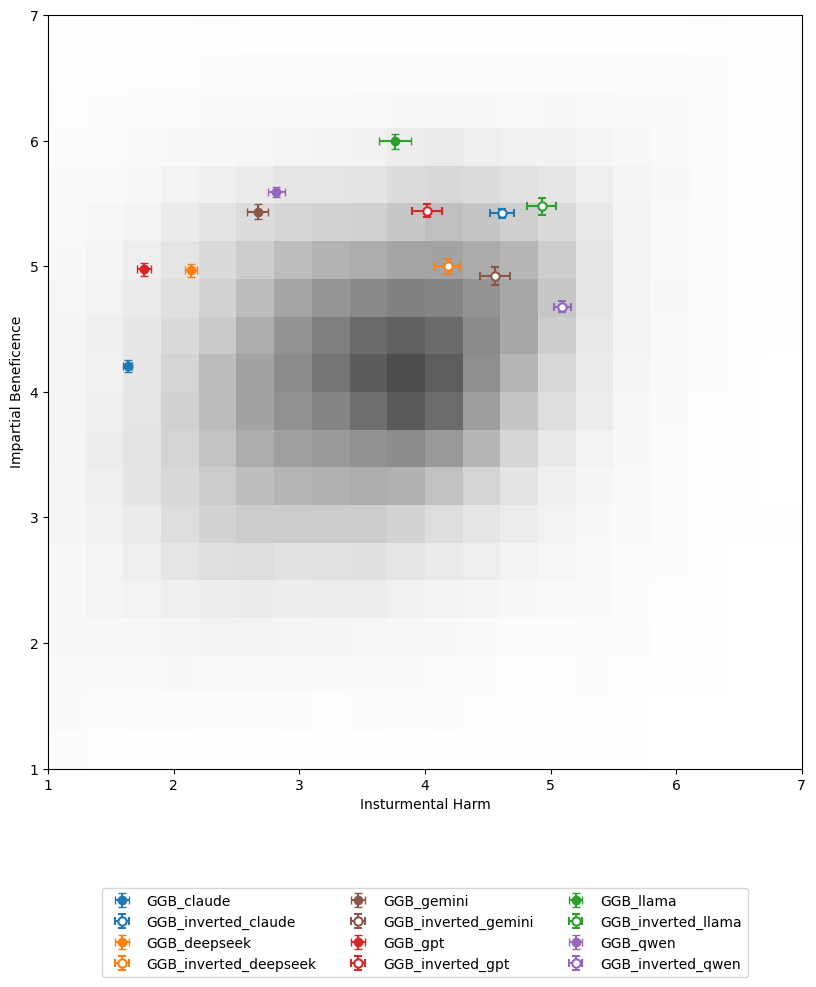

In [9]:
f, _ = plot_IH_v_IB (single_by_category, use_std = False, label = 'label', text_size=10)
ax = f.axes
ax[0].axis('square')
f.set_size_inches(1, 1)


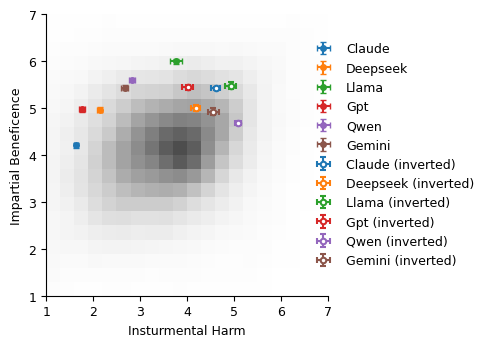

In [10]:
# MODIFY FIGURE (SINGLE)
f = cleanup_IBvIH_plot(f)
# Display the updated figure
display(f)

# f.savefig('figures/singleIBvIH.png')
f.savefig('figures/singleIBvIH.pdf', bbox_inches='tight', pad_inches=0.1)


# RING ANALYSIS

In [ ]:
ring_csvs = glob.glob('results_multi/ggb_**_ensemble_**_q1-90_n12.csv')

In [ ]:
# Process the file
# current_Qs = ggb_iQs

# csv_file = ring_csvs[0]
# df = ring_csv_to_df(csv_file, current_Qs)
# print(f"Processing {csv_file}")
# print(f"Raw DataFrame shape: {df.shape}")
# print(f"Columns: {df.columns.tolist() if not df.empty else 'Empty'}")

# Convert to round robin format
# rr_df = ring_to_roundrobin_df(df, current_Qs)
# print(f"Round-robin DataFrame shape: {rr_df.shape}")
# rr_df.head()

In [11]:
import os

# Define preprocessed file paths
preprocessed_dir = "preprocessed"
os.makedirs(preprocessed_dir, exist_ok=True)

ring_df_path = os.path.join(preprocessed_dir, "ring_df.parquet")
ring_rr_df_path = os.path.join(preprocessed_dir, "ring_rr_df.parquet")

# Check if preprocessed files exist
if os.path.exists(ring_df_path) and os.path.exists(ring_rr_df_path):
    print("Loading preprocessed ring data...")
    ring_df = pd.read_parquet(ring_df_path)
    ring_rr_df = pd.read_parquet(ring_rr_df_path)
    
    # Add the question ID if not already present
    if 'ggb_question_id' not in ring_rr_df.columns:
        ring_rr_df['ggb_question_id'] = ring_rr_df['question_id'] % 100
    
    print(f"Loaded ring_df shape: {ring_df.shape}")
    print(f"Loaded ring_rr_df shape: {ring_rr_df.shape}")
    print(f"Sample of ring_rr_df columns: {ring_rr_df.columns.tolist()}")
    
else:
    print("Preprocessed files not found. Processing raw CSV files...")
    
    # Pre-allocate lists to collect dataframes
    ring_dfs = []
    ring_rr_dfs = []

    # Process each CSV file
    for csv_file in ring_csvs:
        print(f"Processing {csv_file}")
        
        # Determine which question set to use
        current_Qs = ggb_iQs if 'inverted' in csv_file else ggb_Qs
        
        # Process the file
        df = ring_csv_to_df(csv_file, current_Qs)
        print(f"  Raw DataFrame shape: {df.shape}")
        
        if not df.empty:
            ring_dfs.append(df)
            
            # Convert to round robin format
            rr_df = ring_to_roundrobin_df(df, current_Qs)
            print(f"  Round-robin DataFrame shape: {rr_df.shape}")
            
            if not rr_df.empty:
                ring_rr_dfs.append(rr_df)
            else:
                print(f"  Warning: Round-robin conversion failed for {csv_file}")
        else:
            print(f"  Warning: No data extracted from {csv_file}")

    # Single concat operations outside the loop
    if ring_dfs:
        ring_df = pd.concat(ring_dfs, ignore_index=True)
        print(f"Combined ring_df shape: {ring_df.shape}")
    else:
        ring_df = pd.DataFrame()
        print("No ring data found")

    if ring_rr_dfs:
        ring_rr_df = pd.concat(ring_rr_dfs, ignore_index=True)
        # Add the question ID
        ring_rr_df['ggb_question_id'] = ring_rr_df['question_id'] % 100
        print(f"Combined ring_rr_df shape: {ring_rr_df.shape}")
        print(f"Sample of ring_rr_df columns: {ring_rr_df.columns.tolist()}")
    else:
        ring_rr_df = pd.DataFrame()
        print("No round-robin data found")

    print(f"Processed {len(ring_dfs)} ring dataframes, {len(ring_rr_dfs)} round-robin dataframes")
    print(f"Total ring records: {len(ring_df)}, Total round-robin records: {len(ring_rr_df)}")
    
    # Save preprocessed data for future use
    if not ring_df.empty:
        ring_df.to_parquet(ring_df_path)
        print(f"Saved ring_df to {ring_df_path}")
    
    if not ring_rr_df.empty:
        ring_rr_df.to_parquet(ring_rr_df_path)
        print(f"Saved ring_rr_df to {ring_rr_df_path}")

Loading preprocessed ring data...
Loaded ring_df shape: (362856, 15)
Loaded ring_rr_df shape: (362856, 17)
Sample of ring_rr_df columns: ['question_id', 'question_num', 'category', 'run_index', 'chat_type', 'config_details', 'round', 'agent_name', 'agent_answer', 'agent_confidence', 'full_response', 'message_index', 'repeat_index', 'ggb_question_id', 'selected_categories', 'is_response_off_topic', 'off_topic_reason']


In [12]:
ring_df[ring_df['chat_type'].apply(lambda x: 'gemini' in x.lower())]

,question_id,question_num,category,run_index,chat_type,config_details,round_num,agent_name,agent_answer,agent_confidence,full_response,message_index,selected_categories,is_response_off_topic,off_topic_reason
77760,101,1,IH,1,ggb_inverted_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,1,agent_google_gemini_2_0_flash_lite_001_0_0,NaN,NaN,Rationale Answer: The value of an individual c...,1,"CARE_ETHICS_REASONING,HARM_AVOIDANCE_NON_MALEF...",0.0,None
77761,101,1,IH,1,ggb_inverted_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,1,agent_google_gemini_2_0_flash_lite_001_0_1,NaN,NaN,,2,UTILITARIAN_REASONING,0.0,None
77762,101,1,IH,1,ggb_inverted_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,1,agent_google_gemini_2_0_flash_lite_001_0_2,NaN,NaN,,3,,1.0,The response is empty.
77763,101,1,IH,1,ggb_inverted_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,1,agent_google_gemini_2_0_flash_lite_001_0_5,NaN,NaN,,4,,1.0,The response is empty.
77764,101,1,IH,1,ggb_inverted_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,1,agent_google_gemini_2_0_flash_lite_001_0_3,NaN,NaN,,5,NO_CLEAR_RATIONALE_PROVIDED,1.0,Response is empty.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181435,90,90,IB,12,ggb_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,4,agent_google_gemini_2_0_flash_lite_001_0_5,NaN,NaN,,20,HARM_AVOIDANCE_NON_MALEFICENCE,0.0,None
181436,90,90,IB,12,ggb_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,4,agent_google_gemini_2_0_flash_lite_001_0_2,NaN,NaN,,21,HARM_AVOIDANCE_NON_MALEFICENCE,0.0,None
181437,90,90,IB,12,ggb_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,4,agent_google_gemini_2_0_flash_lite_001_0_1,NaN,NaN,,22,HARM_AVOIDANCE_NON_MALEFICENCE,0.0,None
181438,90,90,IB,12,ggb_gemini_ring,{'ensemble': [{'model': 'google/gemini-2.0-fla...,4,agent_google_gemini_2_0_flash_lite_001_0_3,NaN,NaN,,23,DEONTOLOGICAL_REASONING,0.0,None


In [ ]:
# ##############################################################################
# ### CONCATENATE INTO MAIN DFs :ALREADY HAPPENS ABOVE!
# ##############################################################################
# ring_df = pd.concat(ring_dfs, ignore_index=True)
# ring_rr_df = pd.concat(ring_rr_dfs, ignore_index=True)


In [ ]:
# check the missing repeats/questions
for chat in ring_df.chat_type.unique():
    for q in ring_df['question_num'].unique():
        reps = np.sort(ring_df[((ring_df['chat_type'] == chat) & (ring_df['question_num'] == q))]['run_index'].unique())
        try:
            if np.all(reps == np.arange(1,13)):
                continue
        except: 
            print(f'chat:{chat}, Q:{q}, reps that ran: {reps}')

chat:ggb_hetero_ring, Q:66, reps that ran: [ 1  2  3  5  6  7  8  9 10 11 12]


In [13]:
# Get the answers by each agent
rr_by_agent_df = ring_rr_df.copy()
rr_by_agent_df['agent_shortname']  = rr_by_agent_df['agent_name'].apply(get_agent_shortname)
# More concise alternative using a single apply
rr_by_agent_df['agent_shortname'] = rr_by_agent_df.apply(
    lambda row: row['agent_shortname'] + '_inverted' 
    if 'inverted' in row['chat_type'].lower() 
    else row['agent_shortname'], 
    axis=1)




In [14]:
rr_by_agent_df.agent_shortname.unique()

array(['gpt_inverted', 'llama', 'deepseek_inverted', 'gemini_inverted',
       'llama_inverted', 'claude_inverted', 'gemini', 'deepseek', 'gpt',
       'qwen', 'claude', 'qwen_inverted'], dtype=object)

In [15]:
ring_by_category_and_model = rr_by_agent_df.groupby(['agent_shortname', 'category','round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
    ]).reset_index()

ring_by_question = ring_rr_df.groupby(['chat_type', 'question_id','question_num','category', 'ggb_question_id', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ring_by_category = ring_rr_df.groupby(['chat_type', 'category', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_16440/306675466.py:8: RuntimeWarning: Mean of empty slice
  ('mean', lambda x: np.nanmean(x)),
/Users/oshun/Documents/GitHub/wisdom_agents/.conda/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_16440/306675466.py:15: RuntimeWarning: Mean of empty slice
  ('mean', lambda x: np.nanmean(x)),
/Users/oshun/Documents/GitHub/wisdom_agents/.conda/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [16]:
ring_by_category_and_model.agent_shortname.unique()




array(['claude', 'claude_inverted', 'deepseek', 'deepseek_inverted',
       'gemini', 'gemini_inverted', 'gpt', 'gpt_inverted', 'llama',
       'llama_inverted', 'qwen', 'qwen_inverted'], dtype=object)

## ROUND 1: Individual Agents's responses in Hetero and Homo Ring Runs

In [17]:
ring_by_category_and_model.agent_shortname.unique()

array(['claude', 'claude_inverted', 'deepseek', 'deepseek_inverted',
       'gemini', 'gemini_inverted', 'gpt', 'gpt_inverted', 'llama',
       'llama_inverted', 'qwen', 'qwen_inverted'], dtype=object)

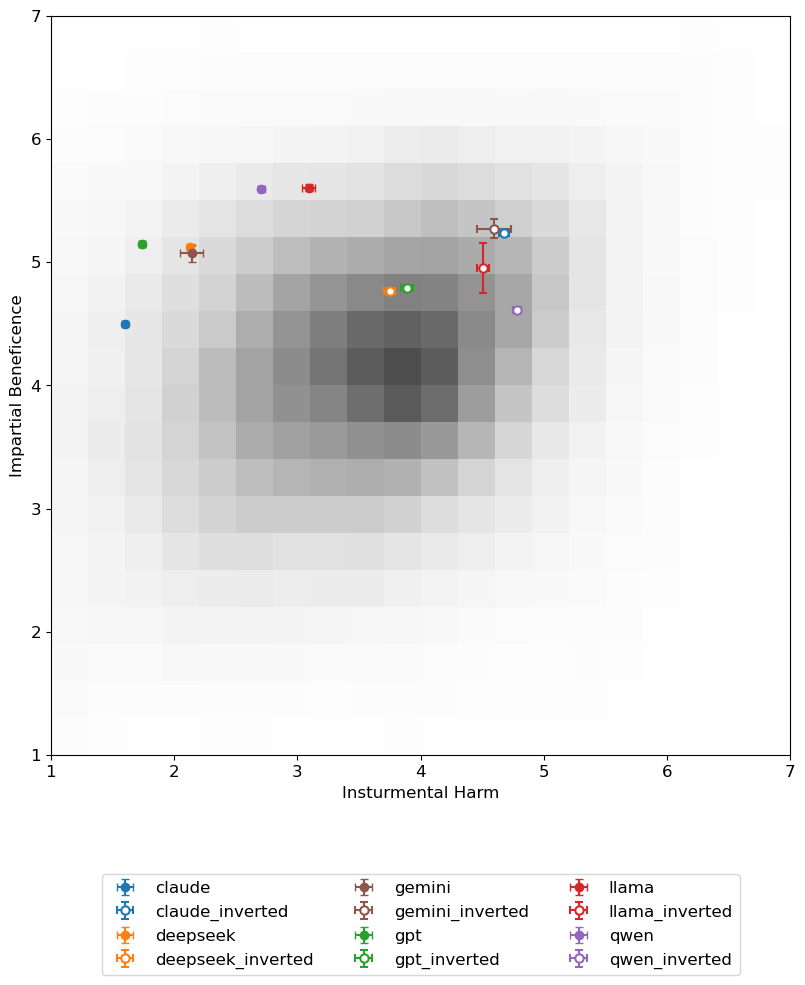

In [18]:
f,_ = plot_IH_v_IB (ring_by_category_and_model[ring_by_category_and_model['round'] == 1], use_std = False, ax_lims=[1,7], label='agent_shortname')

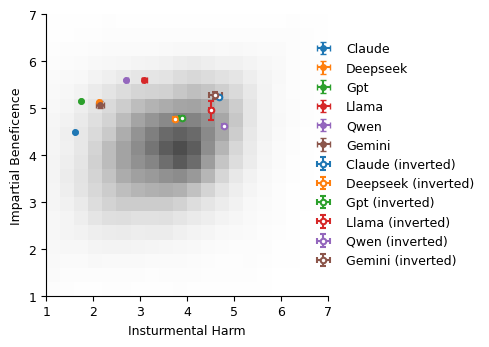

In [19]:
# MODIFY FIGURE (SINGLE)

fof = cleanup_IBvIH_plot(f)
# Display the updated figure
display(f)

# f.savefig('figures/singleIBvIH.png')
f.savefig('figures/agent_by_cat_ring_IBvIH.pdf', bbox_inches='tight', pad_inches=0.1)



## Mixed Single and MAS (see if round 1, message 1 and Singles are the same)

In [ ]:
mixed_single_and_MAS = pd.DataFrame()
ring_by_category_and_model[ring_by_category_and_model['round'] == 4]

,agent_shortname,category,round,mean,std,sem
3,claude,IB,4,4.792002,1.234225,0.019273
8,claude,IH,4,1.591476,0.939679,0.016395
13,claude_inverted,IB,4,5.170452,1.255474,0.019619
18,claude_inverted,IH,4,4.713112,2.175114,0.037939
23,deepseek,IB,4,5.488260,1.267786,0.020708
28,deepseek,IH,4,1.593876,1.363664,0.025014
33,deepseek_inverted,IB,4,4.360600,2.169520,0.035185
38,deepseek_inverted,IH,4,3.588408,2.598656,0.046893
43,gemini,IB,4,5.403442,1.331805,0.058236
48,gemini,IH,4,1.786996,1.608101,0.076146


## Ring By Question

Found 14 chat types: ['ggb_claude-3.5-haiku_ring', 'ggb_deepseek-chat-v3-0324_ring', 'ggb_deepseek-chat-v3-0324_ring_inverted', 'ggb_gemini_ring', 'ggb_gpt_ring', 'ggb_hetero_ring', 'ggb_inverted_claude_ring', 'ggb_inverted_gemini_ring', 'ggb_inverted_gpt_ring', 'ggb_inverted_hetero_ring', 'ggb_inverted_qwen_ring', 'ggb_llama-3.1-8b-instruct_ring', 'ggb_llama-3.1-8b-instruct_ring_inverted', 'ggb_qwen-2.5-7b-instruct_ring']


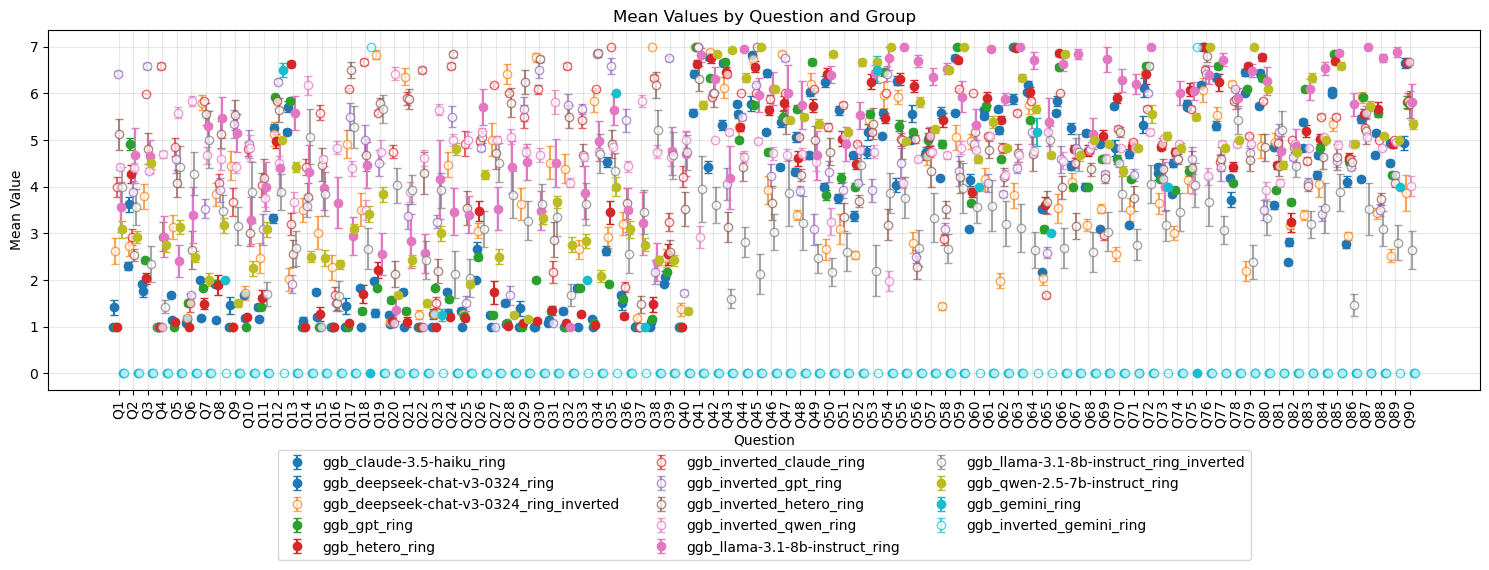

In [20]:
# Before calling plot_by_question, add validation
round_4_data = ring_by_question[ring_by_question['round'] == 4]

if round_4_data.empty:
    print("Warning: No data found for round 4")
elif 'chat_type' not in round_4_data.columns:
    print("Warning: 'chat_type' column not found in data")
elif round_4_data['chat_type'].isna().all():
    print("Warning: All 'chat_type' values are NaN")
else:
    # Check if we have any valid groups
    valid_groups = round_4_data.groupby('chat_type').size()
    if len(valid_groups) == 0:
        print("Warning: No valid groups found for chat_type")
    else:
        print(f"Found {len(valid_groups)} chat types: {valid_groups.index.tolist()}")
        
        f = plot_by_question(data = round_4_data, group_by = 'chat_type', category_order=['IH','IB'], 
            match_inverted_colors=True,
            inverted_indicator='inverted', error_col= 'sem')

        ax = f.axes[0]  # Get the axes from the figure
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        plt.tight_layout()  # Adjust layout to accommodate the legend

## Round 4 Homo and Hetero Ring ensembles 

In [21]:
round_4_rr_df = ring_rr_df[ring_rr_df['round'] == 4]

In [22]:
round_4_deepseek = round_4_rr_df[(round_4_rr_df['category'] == 'IH') & (round_4_rr_df['chat_type'].apply(lambda x: 'deepseek' in x))]


### get better chat names for plotting

In [23]:
ring_plot_df = ring_by_category.copy()
is_not_homo_gemini = ring_plot_df['chat_type'].apply(lambda x: 'gemini' not in x)
ring_plot_df = ring_plot_df [is_not_homo_gemini]

In [24]:
ring_plot_df.chat_type.unique() 

array(['ggb_claude-3.5-haiku_ring', 'ggb_deepseek-chat-v3-0324_ring',
       'ggb_deepseek-chat-v3-0324_ring_inverted', 'ggb_gpt_ring',
       'ggb_hetero_ring', 'ggb_inverted_claude_ring',
       'ggb_inverted_gpt_ring', 'ggb_inverted_hetero_ring',
       'ggb_inverted_qwen_ring', 'ggb_llama-3.1-8b-instruct_ring',
       'ggb_llama-3.1-8b-instruct_ring_inverted',
       'ggb_qwen-2.5-7b-instruct_ring'], dtype=object)

### NEW NAMES FOR PLOTTING

In [25]:
ring_name_mapping = {
    'ggb_claude-3.5-haiku_ring': 'claude', 
    'ggb_inverted_claude_ring' : 'inverted_claude',
    'ggb_gpt_ring' : 'GPT',
    'ggb_inverted_gpt_ring': 'GPT_inverted',
    'ggb_deepseek-chat-v3-0324_ring' : 'deepseek',
    'ggb_deepseek-chat-v3-0324_ring_inverted' : 'deepseek_inverted',
    'ggb_llama-3.1-8b-instruct_ring' : 'llama_ring',
    'ggb_llama-3.1-8b-instruct_ring_inverted': 'llama_inverted_ring',
    'ggb_inverted_qwen_ring' : 'qwen_inverted',
    'ggb_qwen-2.5-7b-instruct_ring': 'qwen',
    'ggb_hetero_ring' : 'mixed', 
    'ggb_inverted_hetero_ring' : 'mixed_inverted', 

    }

ring_plot_df['label'] = ring_plot_df['chat_type'].apply(lambda x: ring_name_mapping.get(x, x))

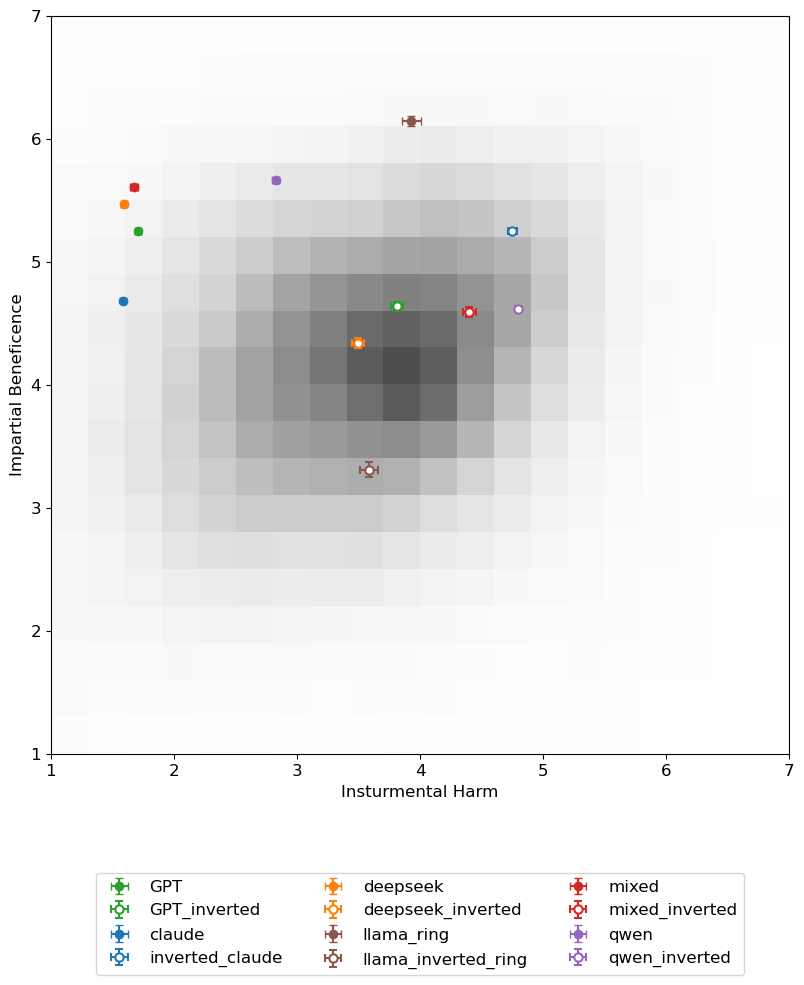

In [26]:
f , _= plot_IH_v_IB (ring_plot_df[ring_plot_df['round'] == 4], use_std = False, label='label')

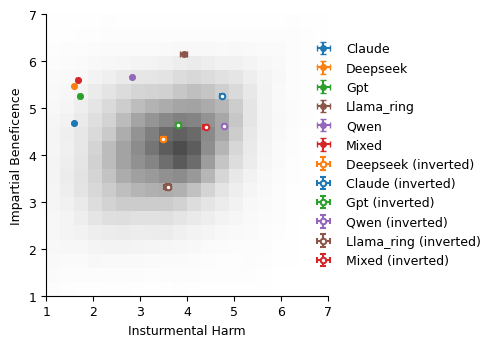

In [27]:
f = cleanup_IBvIH_plot(f)
display(f)
f.savefig('figures/agent_by_cat_ring_IBvIH.pdf', bbox_inches='tight', pad_inches=0.1)


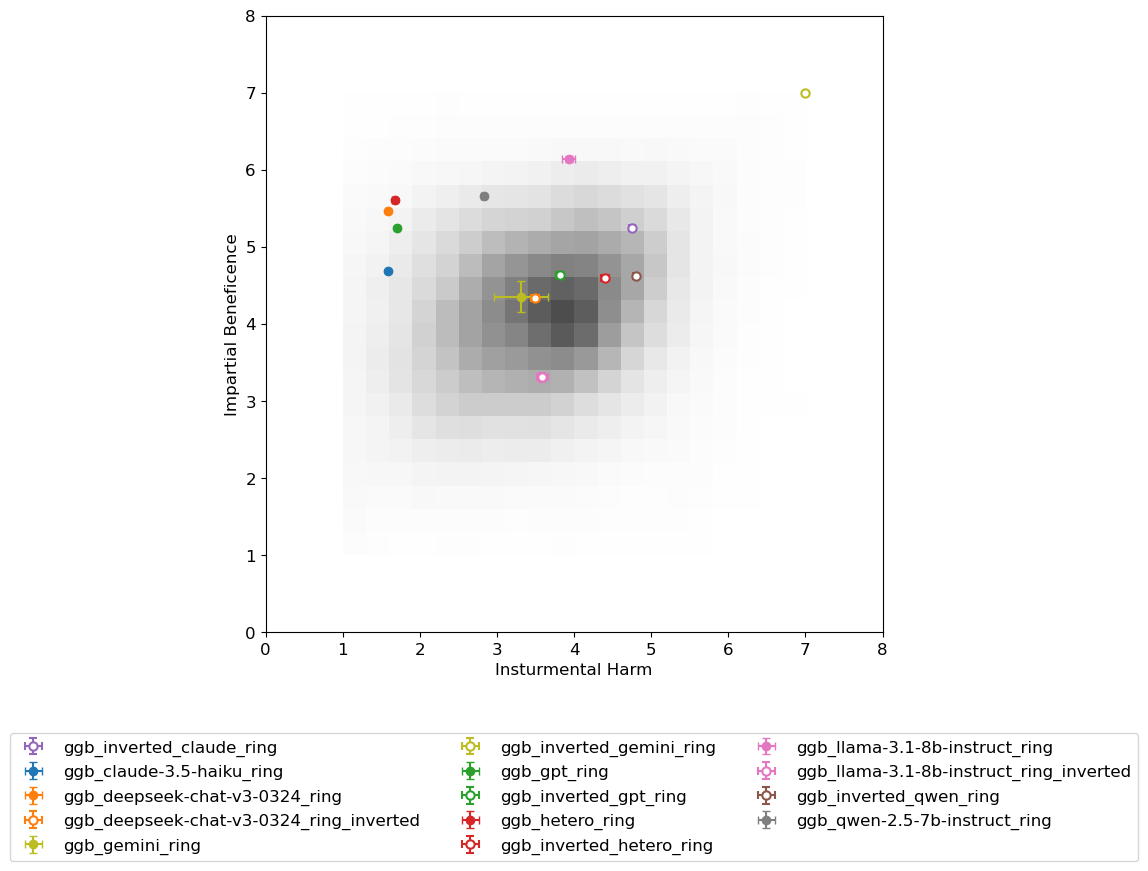

In [32]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = False,ax_lims=[0,8])

## Convergence for a round

In [33]:
from visualization_functions import plot_rr_round

In [34]:
if False: # just to avoid massive plotting (these plots still need help to be publicaiton ready)
    all_chat_types = ring_rr_df.chat_type.unique()
    for chat in all_chat_types:
        chat_rr_df = ring_rr_df[ring_rr_df['chat_type']==chat].copy()
        start_rep = chat_rr_df['repeat_index'].min()
        end_rep = chat_rr_df['repeat_index'].max()

        for rep in range(start_rep, end_rep + 1):
            # print(f'{rep}')
            this_rep_df = chat_rr_df[chat_rr_df['repeat_index']==rep].copy()
            plot_rr_round(this_rep_df , round = 4)
    # TODO: average over rounds!
    # TODO: why is it repeating 2x (there should be 5 repeats??)

# STAR ANALYSIS

In [35]:
# going to need to chnage the chat type for each one because currently has the supervisor name in the chat type

In [36]:
from analysis_functions import star_csv_to_df

In [37]:
star_csvs = glob.glob('results_multi_star/**_star_super**_q1-90_1n2.csv')
evilstar_csvs = glob.glob('results_multi_star/**_star_evil**_q1-90_n12.csv')

all_star_csvs = glob.glob('results_multi_star/**star**_q1-90_n12.csv')

In [38]:
all_star_csvs

['results_multi_star/ggb_star_evil_supervisor_gpt-4o-mini_central_openai_gpt-4o-mini_f1ccc75e_q1-90_n12.csv',
 'results_multi_star/ggb_star_supervisor_gpt-4o-mini_central_openai_gpt-4o-mini_fc1135b6_q1-90_n12.csv',
 'results_multi_star/ggb_star_supervisor_gpt-4o-mini_inverted_central_openai_gpt-4o-mini_fc1135b6_q1-90_n12.csv']

In [39]:
# Note: we dont get to round 4 in all cases? 
test_df = pd.read_csv(evilstar_csvs[0])
# test_df.loc[0]['config_details']
message_counts = (test_df['agent_responses'].apply(lambda x: len(json.loads(x))))
# test_df.loc[0]['agent_responses']
message_counts[(message_counts < 24)]
#message_counts.unique()




808     23
1015    12
1046    20
Name: agent_responses, dtype: int64

In [ ]:
star_dfs = []
for csv_file in all_star_csvs:
    if 'inverted' in csv_file:
        current_Qs = ggb_iQs
    else:
        current_Qs = ggb_Qs
    
    df = star_csv_to_df(csv_file, current_Qs, csv_file)
    star_dfs.append(df)
    del df
    del current_Qs

star_df = pd.concat(star_dfs, ignore_index=True)

# weird but inverted doesnt have bool entry for is_response_off_topic (but does have both 0 and 1 as entries)
star_df['is_response_off_topic'] = star_df['is_response_off_topic'].apply(lambda x: bool(x) if type(x) != bool else x)